In [52]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from PIL import Image
import os

# Function to read file details
def read_file_details(file_path):
    with open(file_path) as f:
        lines = f.readlines()
        dimension_length, dimension_width = map(int, lines[0].split(",")[2:4])
        count_points = int(lines[5])
        data = lines[6:56]
        labels = lines[56:106]
    return dimension_length, dimension_width, count_points, data, labels

# Function to load true coordinates
def load_true_coordinates(data, original_x=30720, original_y=23040, true_x=2048, true_y=1536):
    corrdinate = np.zeros([50, 2])
    for n, line in enumerate(data):
        x, y = map(int, line.split(",")[:2])
        corrdinate[n] = [x * true_x / original_x, y * true_y / original_y]
    return corrdinate

# Function to load labels
def load_labels(labels):
    label_encode = np.zeros(50)
    label_dict = {"Agalg": 0, "DCP": 1, "ROC": 2, "TWS": 3, "CCA": 4, "Davi": 5, "Ana": 6}
    for m, line in enumerate(labels):
        label = line.split(",")[1].replace('\"', '').strip()
        label_encode[m] = label_dict.get(label, 7)  # Default to 7 if label not found
    return label_encode

# Function to write coordinates and labels
def write_coordinates_labels(dir_path, name_image, corrdinate, label_encode):
    name_txt = os.path.splitext(name_image)[0] + '.txt'
    with open(os.path.join(dir_path, name_txt), 'w+') as f:
        f.write(name_image + '\n')
        f.write('x,y,label\n')
        for i in range(50):
            x, y, label = corrdinate[i,0], corrdinate[i,1], int(label_encode[i])
            f.write(f'{x},{y},{label}\n')

# Function to load and crop image
def load_and_crop_image(path_image, corrdinate):
    image = imread(path_image)
    plt.imshow(image)
    all_image = np.zeros([len(corrdinate), 30, 30, 3])  # Allocate space for all cropped images
    height, width, _ = image.shape

    for i in range(len(corrdinate)):
        x, y = int(corrdinate[i,0]), int(corrdinate[i,1])
        # Ensure cropping does not go out of bounds
        x_start, y_start = max(x-15, 0), max(y-15, 0)
        x_end, y_end = min(x+15, width), min(y+15, height)

        cropped_image = image[y_start:y_end, x_start:x_end]
        cropped_height, cropped_width, _ = cropped_image.shape

        # Pad the cropped image if necessary to ensure it has the shape (30, 30, 3)
        padded_image = np.pad(cropped_image, 
                              ((0, 30 - cropped_height), 
                               (0, 30 - cropped_width), 
                               (0, 0)), 
                              mode='constant', 
                              constant_values=0)

        # Now, assign the padded image to all_image
        all_image[i] = padded_image

    return all_image

In [46]:
file_path = "/Volumes/Shaq Toshiba/Cuba CPCe Images/201705233_ROV 17-14_420/201705233_T-16-18-18_113.cpc"
dir_path = '/Users/shagundeepsingh/Documents/coral/new/'
path_image = '/Volumes/Shaq Toshiba/Cuba CPCe Images/201705233_ROV 17-14_420/201705233_T-16-18-18_113.jpg'

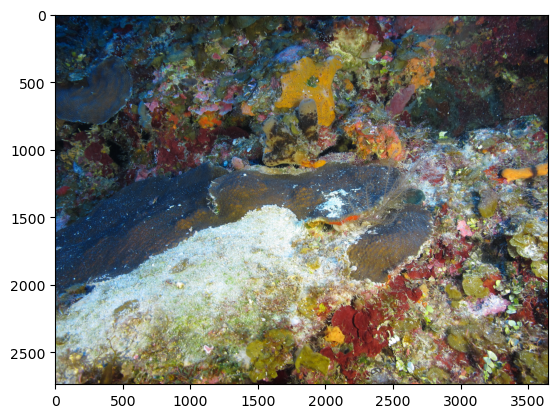

In [47]:
dimension_length, dimension_width, count_points, data, labels = read_file_details(file_path)
corrdinate = load_true_coordinates(data)
label_encode = load_labels(labels)
write_coordinates_labels(dir_path, os.path.basename(path_image), corrdinate, label_encode)
all_image = load_and_crop_image(path_image, corrdinate)


In [48]:
# Function to find matching .cpc and .jpg files
def find_matching_files(directory):
    cpc_files = [f for f in os.listdir(directory) if f.endswith('.cpc')]
    jpg_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    
    # Create a set of base names without extensions for intersection
    cpc_basenames = set(os.path.splitext(f)[0] for f in cpc_files)
    jpg_basenames = set(os.path.splitext(f)[0] for f in jpg_files)
    
    # Find common basenames
    common_basenames = cpc_basenames.intersection(jpg_basenames)
    
    # Create pairs of full file paths for each common basename
    file_pairs = [(os.path.join(directory, f"{name}.cpc"), os.path.join(directory, f"{name}.jpg")) for name in common_basenames]
    return file_pairs

# Main processing function to process each .cpc and .jpg pair
def process_file_pairs(directory, output_directory):
    file_pairs = find_matching_files(directory)
    
    for cpc_path, jpg_path in file_pairs:
        # Process each file pair
        dimension_length, dimension_width, count_points, data, labels = read_file_details(cpc_path)
        corrdinate = load_true_coordinates(data)
        label_encode = load_labels(labels)
        write_coordinates_labels(output_directory, os.path.basename(jpg_path), corrdinate, label_encode)
        all_image = load_and_crop_image(jpg_path, corrdinate)
        # Optionally display or save cropped images
        # plt.imshow(all_image[0]) # Example to display the first cropped image
        # plt.show()

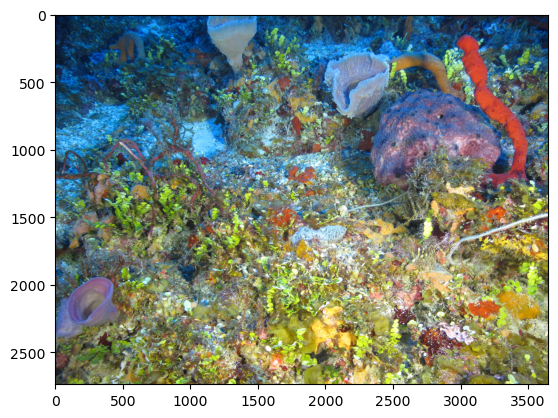

In [53]:
directory = "/Volumes/Shaq Toshiba/Cuba CPCe Images/201705233_ROV 17-14_420/"
output_directory = "/Users/shagundeepsingh/Documents/coral/new/"
process_file_pairs(directory, output_directory)